In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot

In [17]:
data = 'data'

train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory = data,
    batch_size = 64,
    validation_split = 0.2,
    seed = 42,
    output_sequence_length = 16000,
    subset = 'both'
)

label_names = np.array(train_data.class_names)
print(label_names)

Found 7705 files belonging to 8 classes.
Using 6164 files for training.
Using 1541 files for validation.
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [18]:
def squeeze(audio,labels):
    audio = tf.squeeze(audio,axis=-1)
    return audio,labels

In [20]:
training = train_data.map(squeeze,tf.data.AUTOTUNE)
test = test_data.map(squeeze,tf.data.AUTOTUNE)

In [21]:
testing = test.shard(num_shards=2, index =0)
validating = test.shard(num_shards=2, index = 1)

In [22]:
def spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [23]:
def make_dataset(dataset):
    return dataset.map(
        map_func = lambda audio, labels : (spectogram(audio),labels),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [24]:
training = make_dataset(training)
testing = make_dataset(testing)
validating = make_dataset(validating)

In [25]:
training = training.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
testing = testing.cache().prefetch(tf.data.AUTOTUNE)
validating = validating.cache().prefetch(tf.data.AUTOTUNE)

In [26]:
norm_layers = layers.Normalization()
norm_layers.adapt(data = training.map(map_func = lambda spec, labels : spec))

In [27]:
for example_spec, example_label in training.take(1):
    break

input_shape = example_spec.shape[1:]

In [29]:
num_label = len(label_names)
print(num_label)

8


In [30]:
model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layers,
    layers.Conv2D(32,3, activation = 'relu'),
    layers.Conv2D(64,3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_label)
])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [33]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [35]:
history = model.fit(
    training,
    validation_data = validating,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2629 - loss: 1.9244 - val_accuracy: 0.5677 - val_loss: 1.3631
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5404 - loss: 1.3112 - val_accuracy: 0.6680 - val_loss: 1.0274
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6452 - loss: 0.9775 - val_accuracy: 0.7148 - val_loss: 0.8358
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7134 - loss: 0.8013 - val_accuracy: 0.7526 - val_loss: 0.7698
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7554 - loss: 0.6972 - val_accuracy: 0.7812 - val_loss: 0.6748
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7966 - loss: 0.5628 - val_accuracy: 0.8008 - val_loss: 0.6728
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8064 - loss: 0.5396 - val_accuracy: 0.8008 - val_loss: 0.6353
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8309 - loss: 0.4701 - val_accuracy: 0.8242 - v

Text(0, 0.5, 'Accuracy')

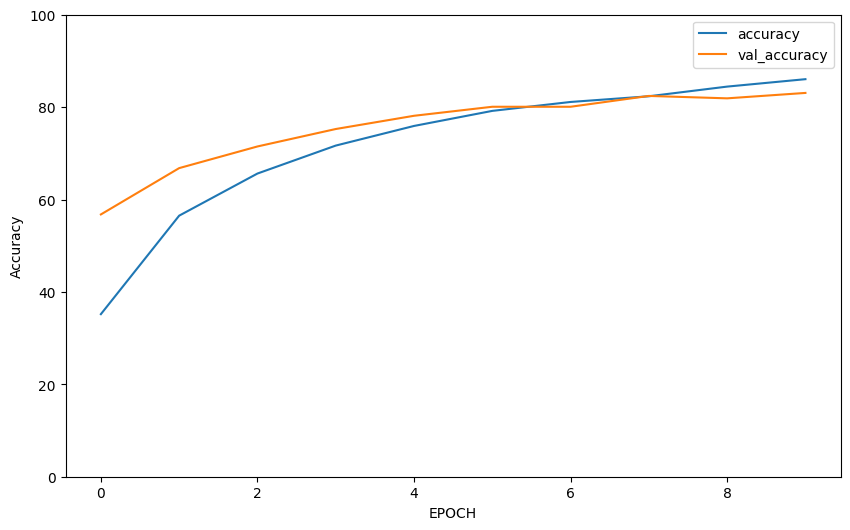

In [36]:
metrics = history.history

plt.figure(figsize = (10,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']),100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.ylim(0,100)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')

In [37]:
result = model.evaluate(testing,return_dict = True)
accuracy = result['accuracy']
print(accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8230 - loss: 0.5480
0.8266494274139404


In [38]:
for i, (spectogram, labels) in enumerate(testing):
    pred = model.predict(spectogram)
    pred_labels_idx = tf.argmax(pred,axis=1).numpy()
    original_label = label_names[labels.numpy()]
    pred_label = [label_names[idx]for idx in pred_labels_idx]

    for j, label in enumerate(original_label):
        print(f"{label}: {pred_label[j]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
stop: stop
up: left
go: no
yes: yes
yes: yes
go: no
yes: yes
no: go
right: right
stop: stop
yes: yes
stop: up
no: no
up: up
left: up
down: down
right: right
go: no
stop: stop
go: right
no: no
no: yes
right: right
no: no
left: left
go: go
right: right
up: up
up: up
go: go
go: no
stop: stop
right: right
down: down
stop: stop
right: right
right: right
left: left
yes: yes
go: go
stop: stop
yes: yes
stop: stop
yes: yes
yes: yes
no: no
no: no
down: stop
up: up
left: yes
yes: yes
up: up
up: up
yes: yes
right: stop
go: go
no: no
no: no
stop: stop
yes: yes
down: no
right: right
no: no
left: left
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
stop: stop
yes: yes
stop: stop
yes: yes
stop: stop
no: no
yes: yes
yes: yes
up: up
down: down
yes: yes
yes: yes
down: down
yes: yes
stop: stop
right: right
no: no
down: down
go: stop
no: no
no: no
up: up
stop: stop
right: right
right: right
left: left
yes: yes
no: no
no: go
go: no
go: go
no: no
no: no
up: up
no: no
left: yes
st